In [1]:
import os

os.chdir("../../")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=1.15, style="whitegrid")

In [2]:
ncg_consumption, gaspool_consumption, the_consumption = ingestion.read_consumption()
consumption_data = pd.concat([ncg_consumption + gaspool_consumption, the_consumption]).dropna()

In [3]:
consumption_data

2016-10-01    1659034.269
2016-10-02    1740912.553
2016-10-03    1916761.578
2016-10-04    2255390.622
2016-10-05    2511773.431
                 ...     
2023-03-01    4010980.998
2023-03-02    3885627.371
2023-03-03    3730179.834
2023-03-04    1841878.128
2023-03-05    1916312.256
Length: 2347, dtype: float64

### Autocorrelation / Seasonality

Text(0, 0.5, 'Correlation coefficient')

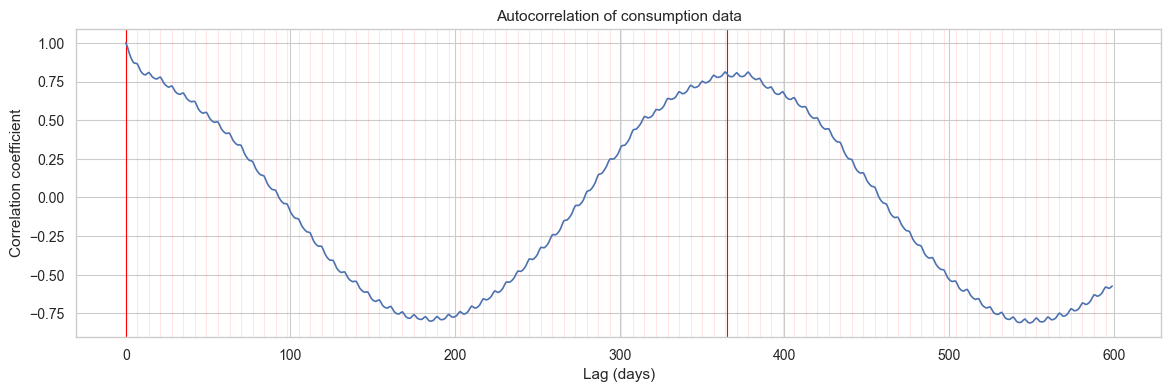

In [4]:
coefficients = []

for lag in range(0, 600):
    coefficients.append(consumption_data.corr(consumption_data.shift(periods=lag)))

fig, ax = plt.subplots(figsize=(14, 4))

# Vertical line at all days divisible by 7
for i in range(0, 600, 7):
    ax.axvline(x=i, color="red", alpha=0.1, linewidth=0.8)

# Vertical line at all days divisible by 365
for i in range(0, 600, 365):
    ax.axvline(x=i, color="red", alpha=1, linewidth=0.8)

ax.plot(range(0, 600), coefficients)

ax.set_title("Autocorrelation of consumption data")
ax.set_xlabel("Lag (days)")
ax.set_ylabel("Correlation coefficient")

# Result: There is a strong correlation between the same day of the week and the same day of the year but not between the same day of the month

c:\Users\linus\anaconda3\envs\ba\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\linus\anaconda3\envs\ba\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


Text(0, 0.5, 'Correlation coefficient')

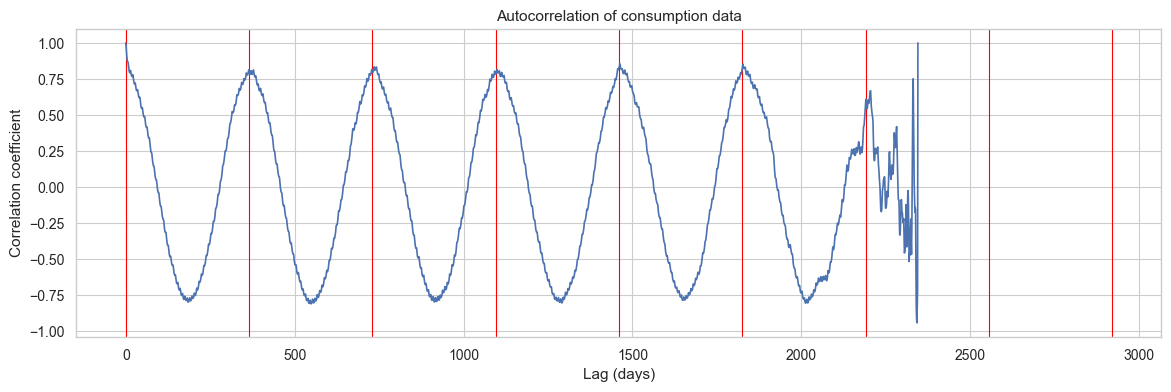

In [5]:
coefficients = []

for lag in range(0, 3000):
    coefficients.append(consumption_data.corr(consumption_data.shift(periods=lag)))

fig, ax = plt.subplots(figsize=(14, 4))

# Vertical line at all days divisible by 365
for i in range(0, 3000, 365):
    ax.axvline(x=i, color="red", alpha=1, linewidth=0.8)

ax.plot(range(0, 3000), coefficients)

ax.set_title("Autocorrelation of consumption data")
ax.set_xlabel("Lag (days)")
ax.set_ylabel("Correlation coefficient")

# How to explain the end of this? -> the coefficient quality deteriorates as the lag increases since the data becomes less and less

### Trends

In [6]:
x = range(consumption_data.shape[0])
y = consumption_data.to_numpy()

In [7]:
# Cut data to only include full years (mitigating risk of seasonality affecting trend estimation)
x = x[0 : (len(x) // 365) * 365]
y = y[0 : (len(y) // 365) * 365]

Text(0, 0.5, 'Consumption (MWh)')

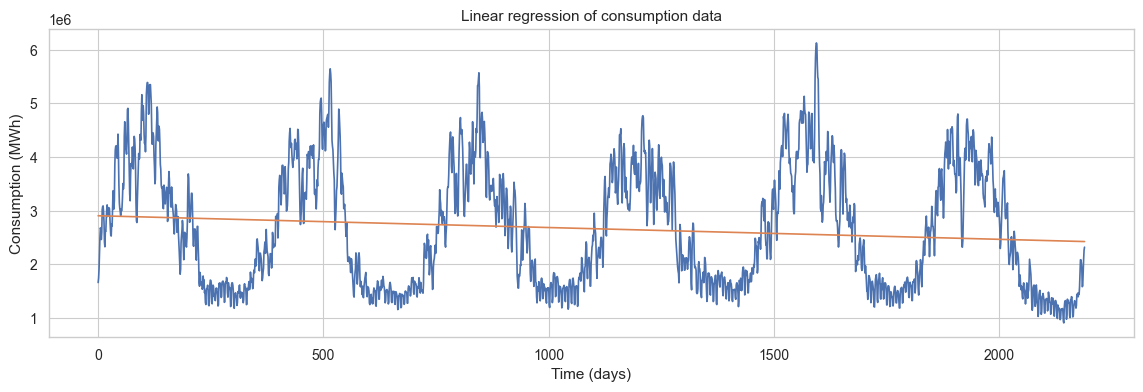

In [8]:
from scipy import stats
linear_regression = stats.linregress(x, y)

# Plot data and linear regression
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(x, y, label="Data")
ax.plot(x, linear_regression.intercept + linear_regression.slope * x, label="Linear regression")

ax.set_title("Linear regression of consumption data")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Consumption (MWh)")

### Decomposition

Decomposition in level, seasonality, trend and noise component

#### Modelling the seasonal behaviour

In [9]:
import numpy as np

def weekly_seasonality(x, a, b, c):
    return a + b * np.sin(2 * np.pi / 7 * x) + c * np.cos(2 * np.pi / 7 * x)

def yearly_seasonality(x, a, b, c):
    return a + b * np.sin(2 * np.pi / 365 * x) + c * np.cos(2 * np.pi / 365 * x)

Text(0, 0.5, 'Natural gas consumption (MWh)')

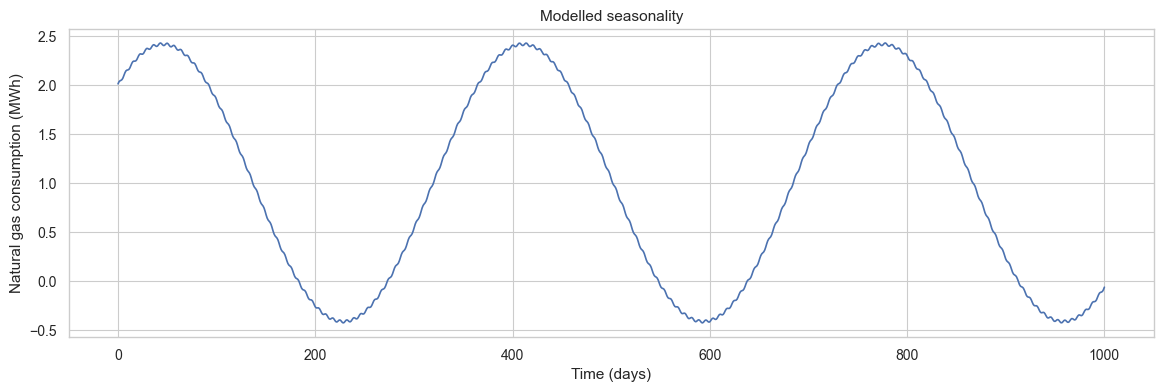

In [10]:
x = np.linspace(0, 1000, 1000)
y = yearly_seasonality(x, 1, 1, 1) + weekly_seasonality(x, 0, 0.01, 0.01)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(x, y)

ax.set_title("Modelled seasonality")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Natural gas consumption (MWh)")

In [11]:
from scipy import optimize

x = np.array(range(consumption_data.index.shape[0]))
y = consumption_data.to_numpy()

parameters_optimal, _ = optimize.curve_fit(yearly_seasonality, x, y)

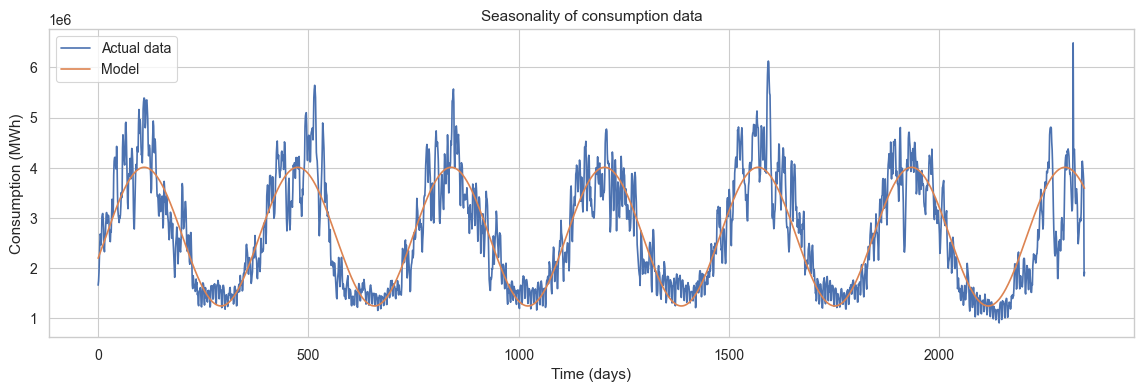

In [12]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(x, y, label="Data")
ax.plot(x, yearly_seasonality(x, *parameters_optimal), label="Seasonality")

ax.set_title("Seasonality of consumption data")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Consumption (MWh)")
ax.legend(["Actual data", "Model"])

In [13]:
def combined_seasonality(x, a, b, c, d, e, f):
    return yearly_seasonality(x, a, b, c) + weekly_seasonality(x, d, e, f)


parameters_optimal, _ = optimize.curve_fit(combined_seasonality, x, y)

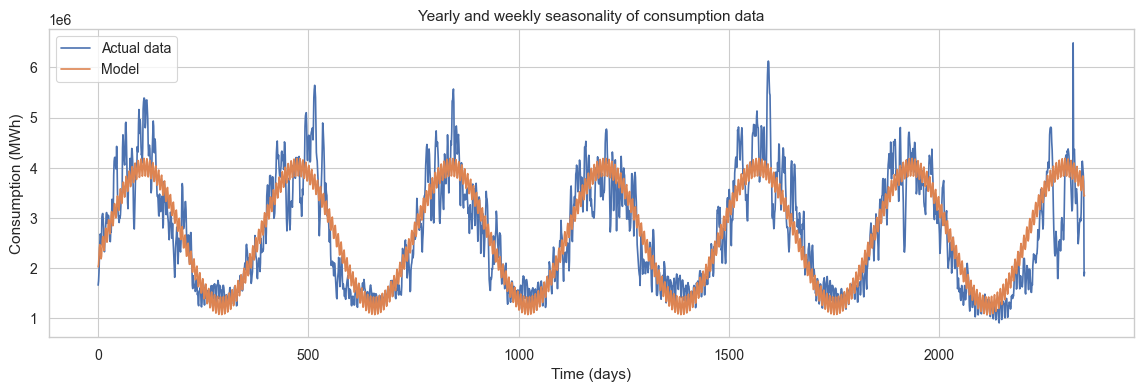

In [14]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(x, y, label="Data")
ax.plot(x, combined_seasonality(x, *parameters_optimal), label="Seasonality")

ax.set_title("Yearly and weekly seasonality of consumption data")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Consumption (MWh)")
ax.legend(["Actual data", "Model"])

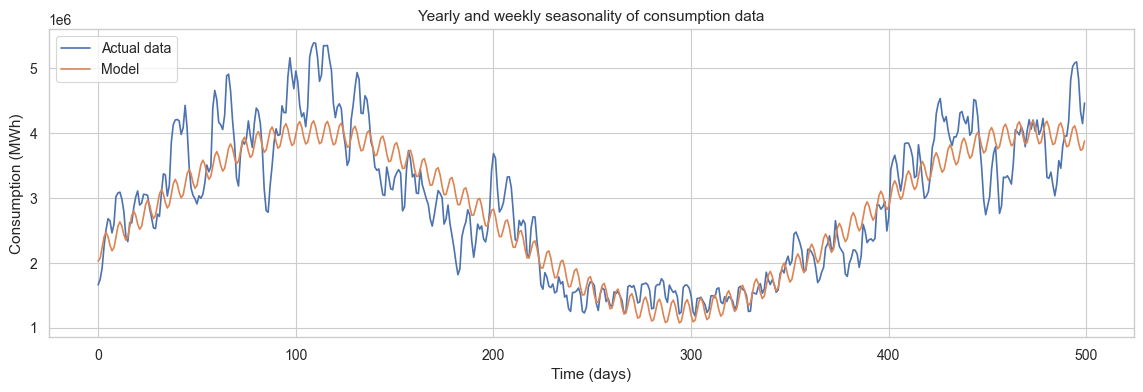

In [15]:
days = 500

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(x[:days], y[:days], label="Data")
ax.plot(
    x[:days], combined_seasonality(x[:days], *parameters_optimal), label="Seasonality"
)

ax.set_title("Yearly and weekly seasonality of consumption data")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Consumption (MWh)")
ax.legend(["Actual data", "Model"])

#### Residual

In [16]:
consumption_data_df = consumption_data.to_frame(name="consumption")
consumption_data_df["seasonal_model"] = combined_seasonality(
    np.array(range(consumption_data.index.shape[0])), *parameters_optimal
)
consumption_data_df["residuals"] = (
    consumption_data_df["consumption"] - consumption_data_df["seasonal_model"]
)

Text(0, 0.5, 'Consumption (MWh)')

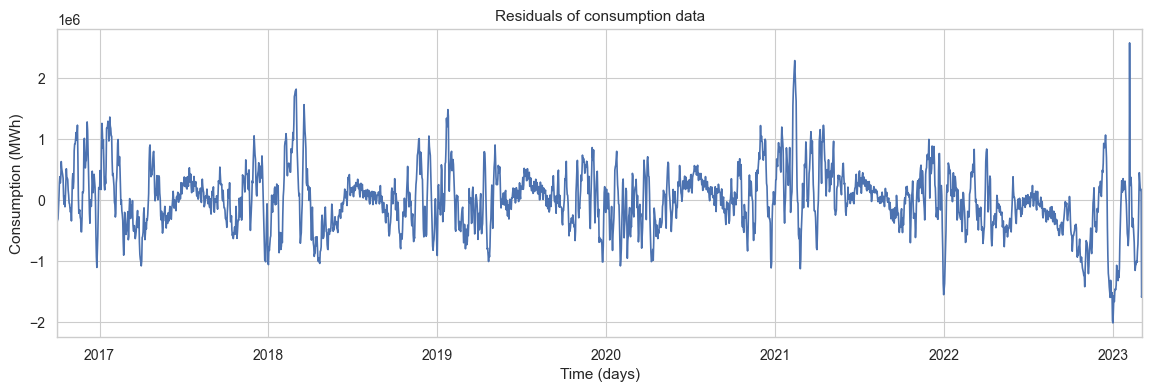

In [17]:
fig, ax = plt.subplots(figsize=(14, 4))

consumption_data_df["residuals"].plot(ax=ax)

ax.set_title("Residuals of consumption data")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Consumption (MWh)")

#### Change for macro trend

In [18]:
from scipy import stats

stats.pearsonr(x, combined_seasonality(x, *parameters_optimal))

PearsonRResult(statistic=-0.010574997724099401, pvalue=0.6086117436062567)

The correlation is not significant, a macro trend is therefore hard to estimate / not there

#### R squared of the seasonal model

In [19]:
from sklearn import metrics

metrics.r2_score(y, combined_seasonality(x, *parameters_optimal))

0.7943935134724927